In [6]:
# ! pip list
# ! pip freeze > requirements.txt
# ! conda env export > environment.yml

In [7]:
# packages needed for the unified framework
# ! pip install git+https://github.com/openai/CLIP.git
# ! pip install open-clip-torch
# ! pip install img2dataset
# ! pip install datasets

In [8]:
# packages needed to run this notebook
# ! pip install git+https://github.com/ginihumer/CLIP-explorer.git
# ! pip install plotly
# ! pip install ipywidgets
# ! pip install scikit-learn
# ! pip install openTSNE
# ! pip install umap-learn


In [9]:
# see https://plotly.com/python/v3/cars-exploration/ for interactive plotly guide

In [10]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

import numpy as np
import plotly.graph_objects as go
from ipywidgets import widgets
import io
from PIL import Image

In [11]:
# cach data for faster interaction
data_checkpoint_dir = 'data_checkpoints/'

if not os.path.exists(data_checkpoint_dir):
    os.makedirs(data_checkpoint_dir)


# Helper functions

In [12]:
from amumo import model
from amumo.model import get_model
# from src.model import get_model
# import src.model as model


def get_embedding(model_name, dataset_name, all_images, all_prompts):
    clip_model = get_model(model_name, device=device)

    data_prefix = dataset_name + '_' + clip_model.model_name + '_' + clip_model.name
    data_prefix = data_prefix.replace('/','-')
    if not os.path.exists(data_checkpoint_dir + data_prefix + '_image-embedding.csv') or not os.path.exists(data_checkpoint_dir + data_prefix + '_text-embedding.csv'):
        with torch.no_grad():
            image_features = clip_model.encode_image(all_images).float()
            text_features = clip_model.encode_text(all_prompts).float()

        np.savetxt(data_checkpoint_dir + data_prefix + '_image-embedding.csv', image_features.cpu(), delimiter = ',')
        np.savetxt(data_checkpoint_dir + data_prefix + '_text-embedding.csv', text_features.cpu(), delimiter = ',')
    else:
        print('found cached embeddings for', data_prefix)
        image_features = torch.from_numpy(np.genfromtxt(data_checkpoint_dir + data_prefix + '_image-embedding.csv', delimiter=","))
        text_features = torch.from_numpy(np.genfromtxt(data_checkpoint_dir + data_prefix + '_text-embedding.csv', delimiter=","))

    return image_features/image_features.norm(dim=-1, keepdim=True), text_features/text_features.norm(dim=-1, keepdim=True)


def get_similarity(image_features_norm, text_features_norm):
    # similarity between images and texts
    similarity = text_features_norm.cpu().numpy() @ image_features_norm.cpu().numpy().T # text x image 

    # similarity between all features
    features_norm = torch.cat((image_features_norm, text_features_norm), dim = 0)
    similarity_features = features_norm.cpu().numpy() @ features_norm.cpu().numpy().T
    
    return similarity, similarity_features


import scipy
import scipy.cluster.hierarchy as sch

def get_cluster_sorting(similarity):
    # adapted from https://wil.yegelwel.com/cluster-correlation-matrix/
    linkage = sch.linkage(1-similarity, method='complete')
    cluster_distance_threshold = (1-similarity).max()/2
    idx_to_cluster_array = sch.fcluster(linkage, cluster_distance_threshold, criterion='distance')
    idx = np.argsort(idx_to_cluster_array)
    return idx, idx_to_cluster_array[idx], idx_to_cluster_array


from sklearn.feature_extraction.text import CountVectorizer
def aggregate_texts(emb_ids, all_prompts, input_type=None):
    c_vec = CountVectorizer(ngram_range=(1, 77), stop_words="english")
    ngrams = c_vec.fit_transform([all_prompts[int(i)] for i in emb_ids])
    vocab = c_vec.vocabulary_
    count_values = ngrams.toarray().sum(axis=0)
    
    ngrams_sorted = sorted([(count_values[i],k) for k,i in vocab.items()], reverse=False, key=lambda sl: (len(sl[1]), sl[0]))
    
    ngrams_distinct = []
    for i in range(len(ngrams_sorted)):
        ng_count_a = ngrams_sorted[i][0]
        ng_text_a = ngrams_sorted[i][1]

        is_included = False
        for j in range(i+1, len(ngrams_sorted)):
            ng_count_b = ngrams_sorted[j][0]
            ng_text_b = ngrams_sorted[j][1]

            if ng_text_a in ng_text_b and ng_count_a <= ng_count_b:
                is_included = True
                break

        if not is_included:
            ngrams_distinct.append({"text": ng_text_a, "value": int(ng_count_a)})
    
    return (sorted(ngrams_distinct, key=lambda i: i['value'], reverse=True), "text-value")
    # return (sorted([{"value": int(count_values[i]), "text": k} for k,i in vocab.items()], key=lambda i: i["value"], reverse=True), "text-value")
    
def get_textual_label_for_cluster(emb_ids, all_prompts, k=2):
    ngrams,_ = aggregate_texts(emb_ids, all_prompts)
    return ' | '.join([ngram["text"] for ngram in ngrams[:k]])

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn as nn
import pandas as pd

def l2_norm(x):
    return x/np.linalg.norm(x, axis=-1, keepdims=True)

def get_modality_gap(modal1_features, modal2_features):
    return modal1_features.mean(axis=0) - modal2_features.mean(axis=0)

def get_modality_gap_normed(modal1_features, modal2_features):
    # with the normed vector, we can use a delta value that defines how much we want to go in each direction
    return l2_norm(get_modality_gap(modal1_features, modal2_features))

def get_modality_distance(modal1_features, modal2_features):
    # Euclidean distance between mass centers
    return np.linalg.norm(get_modality_gap(modal1_features, modal2_features))

# give two lists of features, calculate loss

def calculate_val_loss(image_features_np, text_features_np, logit_scale = 100.0):
# give two lists of features, calculate loss

    # normalized features
    image_features_np /= np.linalg.norm(image_features_np, axis=-1, keepdims=True) + 1e-12
    text_features_np /= np.linalg.norm(text_features_np, axis=-1, keepdims=True) + 1e-12

    total_loss_list = list()

    loss_img = nn.CrossEntropyLoss()
    loss_txt = nn.CrossEntropyLoss()

    BATCH_SIZE = 50 # 5000 in total. 
    for idx in range(len(image_features_np)//BATCH_SIZE):
        
        with torch.no_grad():
            image_features = image_features_np[idx*50:(idx+1)*50]
            text_features  = text_features_np[idx*50:(idx+1)*50]      
        
            # cosine similarity as logits
            logits_per_image = logit_scale * image_features @ text_features.t()
            logits_per_text = logits_per_image.t()

            # # symmetric loss function
            labels = torch.arange(BATCH_SIZE,dtype=torch.long)#.cuda()
            loss_i = loss_img(logits_per_image, labels)
            loss_t = loss_txt(logits_per_text.T, labels)
            total_loss = (loss_i + loss_t)/2
            
            total_loss_list.append(total_loss.item())
    avg_val_loss = np.mean(total_loss_list)
    # print('avg_val_loss', avg_val_loss)
    return avg_val_loss


def get_gap_direction(image_features_np, text_features_np, pca):
    image_features_np /= np.linalg.norm(image_features_np, axis=-1, keepdims=True) + 1e-12
    text_features_np /= np.linalg.norm(text_features_np, axis=-1, keepdims=True) + 1e-12

    pca_result = pca.transform(image_features_np)
    pca_result2 = pca.transform(text_features_np)
    pca_one_delta = pca_result2[:,0].mean() - pca_result[:,0].mean()

    return np.sign(pca_one_delta)




ModuleNotFoundError: No module named 'seaborn'

# Widget components

In [17]:
import traitlets


class SimilarityHeatmapWidget(widgets.VBox):
    
    value = traitlets.Any(np.zeros((6,6))).tag(sync=True)
    cluster = traitlets.Any().tag(sync=True)

    hover_idx = traitlets.List([]).tag(sync=True)


    def __init__(self, zmin=None, zmax=None):
        super(SimilarityHeatmapWidget, self).__init__()

        self.fig_widget = go.FigureWidget(data=[go.Heatmap(z=self.value, zmin=zmin, zmax=zmax)])
        self.heatmap = self.fig_widget.data[0]
        self.heatmap.hoverinfo = "text"
        self.fig_widget.update_layout(width=500, height=420,
            xaxis = dict(
                tickmode = 'array',
                tickvals = [len(self.value)/4, 3*len(self.value)/4],
                ticktext = ['Image', 'Text']
            ),
            yaxis = dict(
                tickmode = 'array',
                tickvals = [len(self.value)/4, 3*len(self.value)/4],
                ticktext = ['Image', 'Text']
            ),
            margin=dict(l=10, r=10, t=10, b=10),
        )
        self.fig_widget.update_yaxes(autorange='reversed', fixedrange=False)
        self.fig_widget.update_xaxes(fixedrange=False)
        self.fig_widget.layout.shapes = self._get_matrix_gridlines()

        self.children = [widgets.HBox([self.fig_widget])]



    def _get_matrix_gridlines(self):
        return [
            go.layout.Shape(type='line', x0=len(self.value)/2-0.5, y0=0-0.5, x1=len(self.value)/2-0.5, y1=len(self.value)-0.5, line=dict(color="black", width=1)),
            go.layout.Shape(type='line', y0=len(self.value)/2-0.5, x0=0-0.5, y1=len(self.value)/2-0.5, x1=len(self.value)-0.5, line=dict(color="black", width=1))
        ]


    @traitlets.validate("value")
    def _validate_value(self, proposal):
        # print("TODO: validate value")
        return proposal.value

    @traitlets.observe("value")
    def onUpdateValue(self, change):
        self.fig_widget.data[0].z = self.value
        self.fig_widget.layout.shapes = self._get_matrix_gridlines()

        self.fig_widget.update_layout(
            xaxis = dict(tickvals = [len(self.value)/4, 3*len(self.value)/4]),
            yaxis = dict(tickvals = [len(self.value)/4, 3*len(self.value)/4])
        )


    # @traitlets.validate("cluster")
    # def _validate_cluster(self, proposal):
        # takes a list of cluster labels + sizes
    #     print("TODO: validate cluster")
    #     return proposal.value

    @traitlets.observe("cluster")
    def onUpdateCluster(self, change):
        cluster_shapes = self._get_matrix_gridlines()
        labels, sizes = self.cluster
        offset = 0-0.5 # -0.5 because heatmap rectangles are drawn around [-0.5, 0.5]
        for (cluster_label, cluster_size) in zip(labels, sizes):
            if cluster_size > 5:
                textposition = 'middle left' if offset < len(self.value)/2/2 else 'middle right'

                # see https://plotly.com/python/shapes/
                cluster_shapes += [go.layout.Shape(
                    type='rect', 
                    x0=len(self.value)/2+offset, 
                    y0=offset, 
                    x1=len(self.value)/2+offset+cluster_size, 
                    y1=offset+cluster_size, 
                    label=dict(text=cluster_label, textposition=textposition, font=dict(size=10, color="white"), padding=cluster_size*5), 
                    line=dict(width=1, color='white')
                )]

            offset += cluster_size
            
        self.fig_widget.layout.shapes = cluster_shapes


    @traitlets.observe("hover_idx")
    def onUpdateHoverIdx(self, change):
        shapes = [sh for sh in self.fig_widget.layout.shapes if sh.name != 'hover_idx' and sh.name != 'hover_idx']

        for (x_idx, y_idx) in self.hover_idx:
            if x_idx >= 0 and x_idx < len(self.value):
                shapes.append(go.layout.Shape(name='hover_idx', type='line', x0=x_idx, y0=0-0.5, x1=x_idx, y1=len(self.value)-0.5, line=dict(color="grey", width=1)))
            if y_idx >= 0 and y_idx < len(self.value):
                shapes.append(go.layout.Shape(name='hover_idx', type='line', y0=y_idx, x0=0-0.5, y1=y_idx, x1=len(self.value)-0.5, line=dict(color="grey", width=1)))
        
        self.fig_widget.layout.shapes = shapes

In [18]:

class HoverWidget(widgets.VBox):
    
    valueX = traitlets.Any().tag(sync=True)
    valueY = traitlets.Any().tag(sync=True)


    def __init__(self, width=300):
        super(HoverWidget, self).__init__()

        self.width = width

        output_dummy_img = io.BytesIO()
        Image.new('RGB', (self.width,self.width)).save(output_dummy_img, format="JPEG")
        self.img_widgets = {'valueX': widgets.Image(value=output_dummy_img.getvalue(), width=0, height=0), 
                            'valueY': widgets.Image(value=output_dummy_img.getvalue(), width=0)} #, height=0)}
        self.txt_widgets = {'valueX': widgets.HTML(value='', layout=widgets.Layout(width="%ipx"%self.width)), 
                            'valueY': widgets.HTML(value='', layout=widgets.Layout(width="%ipx"%self.width)), }
        
        self.children = [widgets.VBox(list(self.txt_widgets.values())), widgets.VBox(list(self.img_widgets.values()))]

        self.layout = widgets.Layout(width="%ipx"%(self.width+10), height="inherit")


    @traitlets.validate("value1", "value2")
    def _validate_value(self, proposal):
        print("TODO: validate value1")
        return proposal.value

    @traitlets.observe("valueX", "valueY")
    def onUpdateValue(self, change):
        cur_img_widget = self.img_widgets[change.name]
        cur_txt_widget = self.txt_widgets[change.name]
        if type(change.new) is io.BytesIO:
            cur_img_widget.value = change.new.getvalue()
            cur_img_widget.width = self.width
            # cur_img_widget.height = self.width
            cur_txt_widget.value = ""
        else:
            cur_txt_widget.value = "<div style='word-wrap: break-word;'>{}</div>".format(change.new)
            cur_img_widget.width = 0
            # cur_img_widget.height = 0


In [19]:

from sklearn.decomposition import PCA
from openTSNE import TSNE
from umap import UMAP

available_projection_methods = {
    'PCA': {'module': PCA, 'OOS':False}, # OOS: flag to signal whether or not out of sample is possible
    'TSNE': {'module': TSNE, 'OOS':False},
    'UMAP': {'module': UMAP, 'OOS':True},
}

class ScatterPlotWidget(widgets.VBox):
    
    embedding = traitlets.Any().tag(sync=True)
    cluster = traitlets.Any().tag(sync=True)

    def __init__(self, seed=31415):
        super(ScatterPlotWidget, self).__init__()

        self.seed=seed

        self.nr_components_widget = widgets.BoundedIntText(
            value=2,
            min=2,
            max=10,
            step=1,
            description='Nr Components:',
            disabled=False,
            layout=widgets.Layout(width="150px")
        )
        self.nr_components_widget.observe(self.onUpdateValue, 'value')

        self.x_component_widget = widgets.BoundedIntText(
            value=1,
            min=1,
            max=10,
            step=1,
            description='X component:',
            disabled=False,
            layout=widgets.Layout(width="150px")
        )
        self.x_component_widget.observe(self.update_scatter, 'value')

        self.y_component_widget = widgets.BoundedIntText(
            value=2,
            min=1,
            max=10,
            step=1,
            description='Y component:',
            disabled=False,
            layout=widgets.Layout(width="150px")
        )
        self.y_component_widget.observe(self.update_scatter, 'value')

        traitlets.dlink((self.nr_components_widget, 'value'), (self.x_component_widget, 'max'))
        traitlets.dlink((self.nr_components_widget, 'value'), (self.y_component_widget, 'max'))


        self.fig_widget = go.FigureWidget()
        self.fig_widget.add_trace(go.Scatter(name = 'image', x=[0,1,2,3], y=[0,1,2,3], mode="markers", marker_color='blue'))
        self.fig_widget.add_trace(go.Scatter(name = 'text', x=[3,2,1,0], y=[0,1,2,3], mode="markers", marker_color='orange'))
        self.fig_widget.update_layout(width=400, 
                                      height=300, 
                                      margin=dict(l=10, r=10, t=10, b=10),
                                      legend=dict(
                                            yanchor="top",
                                            y=0.99,
                                            xanchor="left",
                                            x=0.01  
                                            )
                                      )

        self.scatter_image = self.fig_widget.data[0]
        self.scatter_text = self.fig_widget.data[1]

        self.select_projection_method = widgets.Dropdown(
            description='Method: ',
            value='PCA',
            options=list(available_projection_methods),
        )
        self.select_projection_method.observe(self._update_projection_method, 'value')

        self.use_oos_projection = widgets.Checkbox(
            value=False,
            description='Use out of sample projection',
            disabled=not available_projection_methods[self.select_projection_method.value]['OOS'],
            indent=False
        )
        self.use_oos_projection.observe(self._update_projection_method, 'value')

        
        self.children = [self.select_projection_method, self.use_oos_projection, self.nr_components_widget, widgets.HBox([self.x_component_widget, self.y_component_widget]), self.fig_widget]
        

    def _update_projection_method(self, change):
        print('', available_projection_methods[self.select_projection_method.value]['OOS'])
        self.use_oos_projection.disabled = not available_projection_methods[self.select_projection_method.value]['OOS']
        self.onUpdateValue(change)


    @traitlets.validate("embedding")
    def _validate_value(self, proposal):
        print("TODO: validate embedding")
        return proposal.value

    @traitlets.observe("embedding")
    def onUpdateValue(self, change):
        projection_method = available_projection_methods[self.select_projection_method.value]
        # TODO: add UI for distance metric
        if self.select_projection_method.value == 'PCA':
            projection = projection_method['module'](n_components=self.nr_components_widget.value, random_state=self.seed)
        else:
            projection = projection_method['module'](n_components=self.nr_components_widget.value, metric="cosine", random_state=self.seed)
            

        if not self.use_oos_projection.disabled and self.use_oos_projection.value:
            project_by = 'image' # TODO: add user select for this
    
            if project_by == "image":
                self.image_embedding_projection = projection.fit_transform(self.embedding[:int(len(self.embedding)/2),:])
                self.text_embedding_projection = projection.transform(self.embedding[int(len(self.embedding)/2):,:])
            elif project_by == "text":
                self.text_embedding_projection = projection.fit_transform(self.embedding[int(len(self.embedding)/2):,:])
                self.image_embedding_projection = projection.transform(self.embedding[:int(len(self.embedding)/2),:])

            self.embedding_projection = np.concatenate((self.image_embedding_projection, self.text_embedding_projection))
            
        else:
            if self.select_projection_method.value == 'TSNE':
                self.embedding_projection = projection.fit(self.embedding)
            else:
                self.embedding_projection = projection.fit_transform(self.embedding)

            self.image_embedding_projection = self.embedding_projection[:int(len(self.embedding)/2),:]
            self.text_embedding_projection = self.embedding_projection[int(len(self.embedding)/2):,:]

        self.update_scatter(change)

    def update_scatter(self, change):
        self.scatter_image.x = self.image_embedding_projection[:,self.x_component_widget.value-1]
        self.scatter_image.y = self.image_embedding_projection[:,self.y_component_widget.value-1]

        self.scatter_text.x = self.text_embedding_projection[:,self.x_component_widget.value-1]
        self.scatter_text.y = self.text_embedding_projection[:,self.y_component_widget.value-1]

        lines = []

        for line_idx in range(len(self.text_embedding_projection)):
            lines.append(go.layout.Shape(name='hover_idx', 
                                         type='line', 
                                         x0=self.image_embedding_projection[line_idx,self.x_component_widget.value-1], 
                                         y0=self.image_embedding_projection[line_idx,self.y_component_widget.value-1], 
                                         x1=self.text_embedding_projection[line_idx,self.x_component_widget.value-1], 
                                         y1=self.text_embedding_projection[line_idx,self.y_component_widget.value-1], 
                                         line=dict(color="grey", width=1)))
            # plt.plot((image_embedding_pca[line_idx,0], text_embedding_pca[line_idx,0]), (image_embedding_pca[line_idx,1], text_embedding_pca[line_idx,1]), 'black', linestyle='-', marker='', linewidth=1, alpha=0.2)

        self.fig_widget.layout.shapes = lines


    @traitlets.validate("cluster")
    def _validate_cluster(self, proposal):
        # takes a list of cluster labels + sizes
        # print("TODO: validate cluster")
        return proposal.value

    @traitlets.observe("cluster")
    def onUpdateCluster(self, change):
        print(change)


/Users/christina/anaconda3/envs/myenv3/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/christina/anaconda3/envs/myenv3/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/christina/anaconda3/envs/myenv3/lib/python3.9/site-packag

In [20]:

class CLIPExplorerWidget(widgets.AppLayout):
    idcs = traitlets.Any().tag(sync=True)

    def __init__(self, dataset_name, all_images, all_prompts):
        super(CLIPExplorerWidget, self).__init__()
        
        self.dataset_name = dataset_name
        self.all_images = np.array(all_images)
        self.all_prompts = np.array(all_prompts)
        self.size = len(all_images)
        self.idcs = np.arange(self.size)

        # ui select widgets
        self.model_select_widget = widgets.Dropdown(
            description='Model: ',
            value='CLIP',
            options=list(model.available_CLIP_models),
        )

        self.cluster_similarity_matrix_widget = widgets.Checkbox(
            value=False,
            description='Cluster matrix by similarity',
            disabled=False,
            indent=False
        )

        # output widgets
        self.hover_widget = HoverWidget()

        image_embedding_norm, text_embedding_norm = get_embedding(self.model_select_widget.value, self.dataset_name, self.all_images, self.all_prompts)
        self.scatter_widget = ScatterPlotWidget()
        self.scatter_widget.embedding = np.concatenate((image_embedding_norm, text_embedding_norm))

        similarity_texts_images, similarity_all = get_similarity(image_embedding_norm, text_embedding_norm)
        self.heatmap_widget = SimilarityHeatmapWidget()
        self.heatmap_widget.value = similarity_all

        self.log_widget = widgets.Output()


        # callback functions
        self.model_select_widget.observe(self.model_changed, names="value")
        self.cluster_similarity_matrix_widget.observe(self.model_changed, names='value')
        self.heatmap_widget.heatmap.on_hover(self.hover_fn)
        self.scatter_widget.scatter_image.on_hover(self.scatter_hover_fn)
        self.scatter_widget.scatter_text.on_hover(self.scatter_hover_fn)
        self.scatter_widget.scatter_image.on_unhover(self.scatter_unhover_fn)
        self.scatter_widget.scatter_text.on_unhover(self.scatter_unhover_fn)

        # display everyting
        self.header = widgets.HBox([self.model_select_widget, self.cluster_similarity_matrix_widget, self.log_widget])
        self.header.layout.height = '40px'
        vis_widgets = widgets.HBox([self.heatmap_widget, self.scatter_widget])
        self.center = vis_widgets
        self.right_sidebar = self.hover_widget
        self.height = '700px'


    def model_changed(self, change):
        with self.log_widget:
            print("loading...")

        image_embedding, text_embedding = get_embedding(self.model_select_widget.value, self.dataset_name, self.all_images, self.all_prompts)
        self.scatter_widget.embedding = np.concatenate((image_embedding, text_embedding))

        similarity_texts_images, similarity_all = get_similarity(image_embedding, text_embedding)

        cluster_labels = []
        cluster_sizes = []

        if self.cluster_similarity_matrix_widget.value:
            self.idcs, clusters, clusters_unsorted = get_cluster_sorting(similarity_texts_images)
            for c in set(clusters):
                cluster_size = np.count_nonzero(clusters==c)
                cluster_label = get_textual_label_for_cluster(np.where(clusters_unsorted==c)[0], self.all_prompts)
                cluster_labels.append(cluster_label)
                cluster_sizes.append(cluster_size)
        else:
            self.idcs = np.arange(self.size)

        # with heatmap_widget.batch_update():
        matrix_sort_idcs = np.concatenate([self.idcs, self.idcs+self.size], axis=0) # need to do double index because we combined images and texts
        self.heatmap_widget.value = similarity_all[matrix_sort_idcs, :][:, matrix_sort_idcs]
        self.heatmap_widget.cluster = (cluster_labels, cluster_sizes)

        self.log_widget.clear_output()


    def hover_fn(self, trace, points, state):
        x_idx = points.xs[0]
        y_idx = points.ys[0]
            
        self.heatmap_widget.hover_idx = [(x_idx, y_idx)]

        if x_idx < self.size:
            output_img = io.BytesIO()
            self.all_images[self.idcs][x_idx].resize((300,300)).save(output_img, format='JPEG')
            self.hover_widget.valueX = output_img
        else:
            self.hover_widget.valueX = self.all_prompts[self.idcs][x_idx%self.size]
        
        if y_idx < self.size:
            output_img = io.BytesIO()
            self.all_images[self.idcs][y_idx].resize((300,300)).save(output_img, format='JPEG')
            self.hover_widget.valueY = output_img
        else:
            self.hover_widget.valueY = self.all_prompts[self.idcs][y_idx%self.size]

    def scatter_hover_fn(self, trace, points, state):
        if len(points.point_inds) < 1:
            return
        idx = points.point_inds[0]
        # print(trace.name, idx) # image vs text trace

        self.hover_widget.valueX = self.all_prompts[idx]

        output_img = io.BytesIO()
        self.all_images[idx].resize((300,300)).save(output_img, format='JPEG')
        self.hover_widget.valueY = output_img
        
        inverse_idcs = np.argsort(self.idcs)
        heatmap_idx = inverse_idcs[idx]
        self.heatmap_widget.hover_idx = [(heatmap_idx, self.size + heatmap_idx), (self.size + heatmap_idx, heatmap_idx)]


    def scatter_unhover_fn(self, trace, points, state):
        self.heatmap_widget.hover_idx = []

In [21]:

import math

class CLIPComparerWidget(widgets.AppLayout):


    def __init__(self, dataset_name, all_images, all_prompts, models=list(model.available_CLIP_models)):
        super(CLIPComparerWidget, self).__init__()
        
        self.dataset_name = dataset_name
        self.all_images = np.array(all_images)
        self.all_prompts = np.array(all_prompts)
        self.size = len(all_images)
        
        # output widgets
        self.hover_widget = HoverWidget()

        self.heatmap_grid = widgets.GridspecLayout(math.ceil(len(models)/2), 2)
        for i in range(len(models)):
            model = models[i]
            image_embedding_norm, text_embedding_norm = get_embedding(model, self.dataset_name, self.all_images, self.all_prompts)
            _, similarity_all = get_similarity(image_embedding_norm, text_embedding_norm)
            heatmap_widget = SimilarityHeatmapWidget(zmin=0, zmax=1)
            heatmap_widget.value = similarity_all
            heatmap_widget.heatmap.on_hover(self.hover_fn)
            # heatmap_widget.layout = widgets.Layout(height='500px', width='auto')

            text_widget = widgets.HTML(value='<h2>' + models[i] + '</h2>')

            self.heatmap_grid[int(i/2), i%2] = widgets.VBox([text_widget, heatmap_widget])
            self.heatmap_grid[int(i/2), i%2].layout.height = '500px'

        self.right_sidebar = self.hover_widget
        self.center = self.heatmap_grid
        self.height = '900px'


    def hover_fn(self, trace, points, state):
        x_idx = points.xs[0]
        y_idx = points.ys[0]
            
        for c in self.heatmap_grid.children:
            c.children[1].hover_idx = [(x_idx, y_idx)]

        if x_idx < self.size:
            output_img = io.BytesIO()
            self.all_images[x_idx].resize((300,300)).save(output_img, format='JPEG')
            self.hover_widget.valueX = output_img
        else:
            self.hover_widget.valueX = self.all_prompts[x_idx%self.size]
        
        if y_idx < self.size:
            output_img = io.BytesIO()
            self.all_images[y_idx].resize((300,300)).save(output_img, format='JPEG')
            self.hover_widget.valueY = output_img
        else:
            self.hover_widget.valueY = self.all_prompts[y_idx%self.size]


In [22]:
class ModalityGapWidget(widgets.AppLayout):
    

    def __init__(self, image_embedding, text_embedding, title='Loss Landscape CLIP'):
        super(ModalityGapWidget, self).__init__()
        
        image_embedding = np.array(image_embedding)
        text_embedding = np.array(text_embedding)

        modality_gap = get_modality_gap_normed(image_embedding, text_embedding)
        
        distance_lst = []
        loss_lst = []
        for delta in np.arange(-5.0, 5.0, 0.25): 
            modified_text_features = l2_norm(text_embedding) + 0.5 * delta * modality_gap
            modified_text_features = l2_norm(modified_text_features)

            modified_image_features = l2_norm(image_embedding) - 0.5 * delta * modality_gap
            modified_image_features = l2_norm(modified_image_features)

            avg_val_loss = calculate_val_loss(torch.from_numpy(modified_image_features), torch.from_numpy(modified_text_features), logit_scale = 100.0)

            pca = PCA(n_components=6)
            pca.fit(np.concatenate((image_embedding, text_embedding), axis=0))

            gap_direction = get_gap_direction(modified_image_features, modified_text_features, pca)

            loss_lst.append(avg_val_loss)

            # Euclidean distance between mass centers
            distance_lst.append(
                get_modality_distance(modified_image_features, modified_text_features) * gap_direction
            )


        orig_distance = get_modality_distance(image_embedding, text_embedding)

        fig = go.FigureWidget(data=go.Scatter(x=distance_lst, y=loss_lst, mode='lines+markers', hovertemplate='Distance: %{x} <br>Loss: %{y}'))
        fig.add_shape(type="line",
            x0=orig_distance, y0=0, x1=orig_distance, y1=max(loss_lst)*1.2,
            line=dict(
                color="Black",
                width=1,
                dash="dash",
            )
        )
        fig.update_layout(xaxis_title='Euclidean Distance', yaxis_title='Loss', width=500, title=title)
        
        self.center = widgets.HBox([fig])
        

# Load dataset

In [23]:
# from src.data import get_dataset
# dataset = get_dataset('MSCOCO', '/Users/christina/Data/mscoco/')
# import src.data as data
from amumo import data
# dataset = data.MSCOCO_Dataset(path='/Users/christina/Data/mscoco/')
dataset = data.DiffusionDB_Dataset(path="2m_first_1k")

Found cached dataset diffusiondb (/Users/christina/.cache/huggingface/datasets/poloclub___diffusiondb/2m_first_1k/0.9.1/b3bc1e64570dc7149af62c4bac49ecfbce16b683dd4fee083292fae1afa95f7c)


  0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
all_images, all_prompts = dataset.get_data()
# dataset = data.RandomAugmentation_Dataset(all_images[0], all_prompts[0])
# dataset = data.Rotate_Dataset(all_images[0], all_prompts[0])
# dataset = data.Noise_Dataset(all_images[0], all_prompts[0])


In [20]:
def get_data_helper(dataset, filters=[], method=any):
    all_images, all_prompts = dataset.get_filtered_data(filters, method=method)
    print(len(all_images))

    dataset_name = dataset.name
    if len(filters) > 0:
        dataset_name = dataset_name + '_filter-' + method.__name__ + '_' + '-'.join(filters)
    else:
        dataset_name = dataset_name + '_size-%i'%len(all_images)

    return all_images, all_prompts, dataset_name

all_images, all_prompts, dataset_name = get_data_helper(dataset, filters=[], method=any) # filters = ["dog"], method=all
dataset_name

100


'DiffusionDB_size-100'

In [21]:
image_embedding, text_embedding = get_embedding('CLIP', dataset_name, all_images, all_prompts)
ModalityGapWidget(image_embedding, text_embedding)

found cached embeddings for DiffusionDB_size-100_CLIP_RN50


ModalityGapWidget(children=(HBox(children=(FigureWidget({
    'data': [{'hovertemplate': 'Distance: %{x} <br>L…

In [20]:

clipexplorer = CLIPExplorerWidget(dataset_name, all_images, all_prompts)
clipexplorer

/var/folders/46/rz1kpyy146n3kk5pyv0pqdh80000gn/T/ipykernel_24311/147422823.py:8: FutureWarning:

The input object of type 'PngImageFile' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'PngImageFile', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.

/var/folders/46/rz1kpyy146n3kk5pyv0pqdh80000gn/T/ipykernel_24311/147422823.py:8: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



found cached embeddings for DiffusionDB_CLIP_RN50
TODO: validate embedding


CLIPExplorerWidget(children=(HBox(children=(Dropdown(description='Model: ', options=('CLIP', 'OpenCLIP', 'BLIP…

In [21]:
model.available_CLIP_models

{'CLIP': clipexplorer.model.CLIPModel,
 'OpenCLIP': clipexplorer.model.OpenCLIPModel,
 'BLIP': clipexplorer.model.BLIPModel,
 'CyCLIP': clipexplorer.model.CyCLIPModel,
 'CLOOB': clipexplorer.model.CLOOB_Model,
 'CLOOB_LAION400M': clipexplorer.model.CLOOB_LAION400M_Model}

In [22]:
clip_comparer = CLIPComparerWidget(dataset_name, all_images, all_prompts, models=['CLIP', 'CyCLIP', 'CLOOB', 'CLOOB_LAION400M'])
clip_comparer

/var/folders/46/rz1kpyy146n3kk5pyv0pqdh80000gn/T/ipykernel_24311/853010106.py:10: FutureWarning:

The input object of type 'PngImageFile' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'PngImageFile', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.

/var/folders/46/rz1kpyy146n3kk5pyv0pqdh80000gn/T/ipykernel_24311/853010106.py:10: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



found cached embeddings for DiffusionDB_CLIP_RN50
Loading model from /Users/christina/anaconda3/envs/myenv/lib/python3.9/site-packages/clipexplorer/CLOOB_local/training/model_configs/RN50.json


CLIPComparerWidget(children=(HoverWidget(children=(VBox(children=(HTML(value='', layout=Layout(width='300px'))…

# Do some Benchmarking

In [22]:
all_images, all_prompts = dataset.get_data()
len(all_images), len(all_prompts)
# 3.2s

(100, 100)

In [23]:
image_embedding, text_embedding = get_embedding('CLIP', dataset.name, all_images, all_prompts)
# 12.2s
# 3.1s if cached

found cached embeddings for DiffusionDB_CLIP_RN50


In [24]:
similarity_texts_images, similarity_all = get_similarity(image_embedding, text_embedding)
# 0.0s

In [25]:
_,_,_ = get_cluster_sorting(similarity_texts_images)
# 0.0s

In [26]:
_ = get_textual_label_for_cluster([1,2,3,4,5,6,7,8,9,10], all_prompts)
# 0.0s

# Test stuff

In [27]:
def get_data_helper(dataset, filters=[], method=any):
    all_images, all_prompts = dataset.get_filtered_data(filters, method=method)
    print(len(all_images))

    dataset_name = dataset.name
    if len(filters) > 0:
        dataset_name = dataset_name + '_filter-' + method.__name__ + '_' + '-'.join(filters)
    else:
        dataset_name = dataset_name + '_size-%i'%len(all_images)

    return all_images, all_prompts, dataset_name

all_images, all_prompts, dataset_name = get_data_helper(dataset, filters=[], method=any) # filters = ["dog"], method=all
dataset_name

100


'DiffusionDB_size-100'

In [57]:
image_embedding, text_embedding = get_embedding('CLIP', dataset_name, all_images, all_prompts)
similarity_texts_images, similarity_all = get_similarity(image_embedding, text_embedding)


found cached embeddings for DiffusionDB_size-100_CLIP_RN50


array([ 5,  3,  9,  9,  7,  5,  1,  6,  7,  5, 10,  6,  5,  9,  5, 10,  3,
        6,  1,  9,  8,  7,  7,  4,  5, 10, 10,  2,  9,  5,  9,  8,  4,  5,
       10,  5,  6,  7,  5,  2,  9,  7, 10,  9,  6,  8,  1,  6,  1,  5,  9,
        9,  4,  5,  2,  7,  4,  9,  5,  1,  7, 10, 10,  7,  6,  3,  5,  6,
        6,  6,  7,  7,  9,  1,  1,  1,  5,  6,  3,  1,  6,  7,  6,  7,  5,
        2,  2,  7, 10,  6,  8,  2,  2,  5,  5,  5,  8,  4, 10,  5],
      dtype=int32)

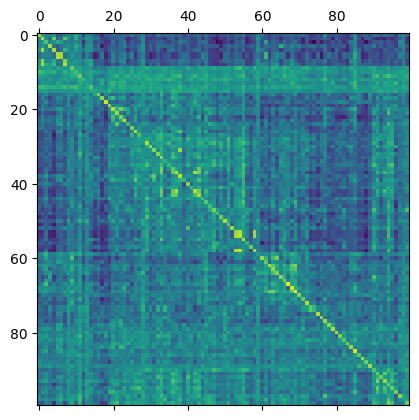

In [58]:
linkage = sch.linkage(1-similarity_texts_images, method='complete')
cluster_distance_threshold = (1-similarity_texts_images).max()/2
idx_to_cluster_array = sch.fcluster(linkage, 10, criterion='maxclust')
idx = np.argsort(idx_to_cluster_array)
plt.matshow(similarity_texts_images[idx, :][:, idx])
idx_to_cluster_array

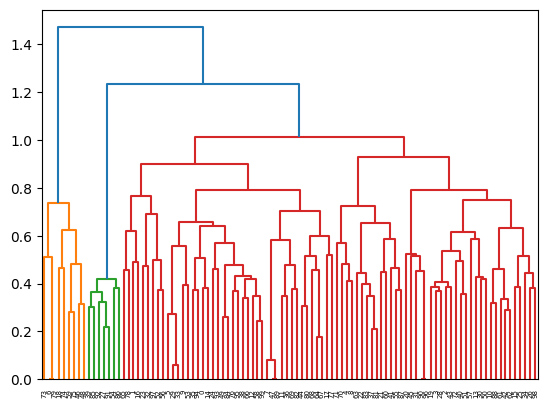

In [59]:
sch.dendrogram(linkage)
plt.show()


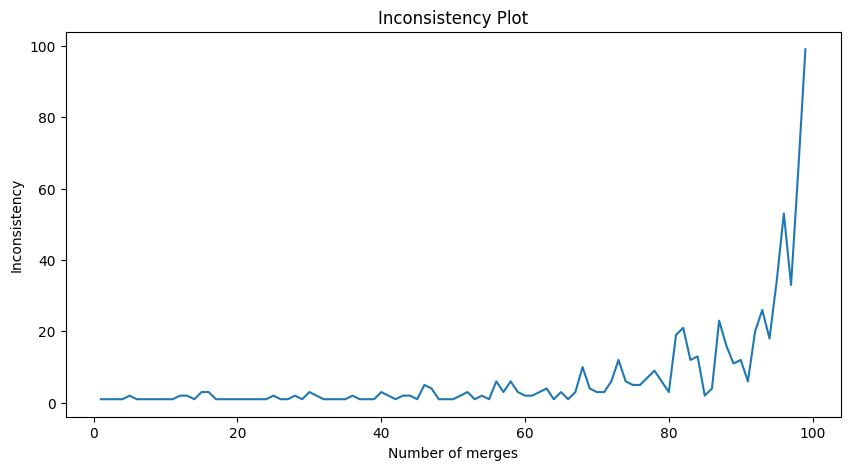

In [41]:
inconsistencies = sch.inconsistent(linkage, 100)
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(inconsistencies) + 1), inconsistencies[:, 2])
plt.xlabel('Number of merges')
plt.ylabel('Inconsistency')
plt.title('Inconsistency Plot')
plt.show()


In [44]:
inconsistencies.shape

(99, 4)

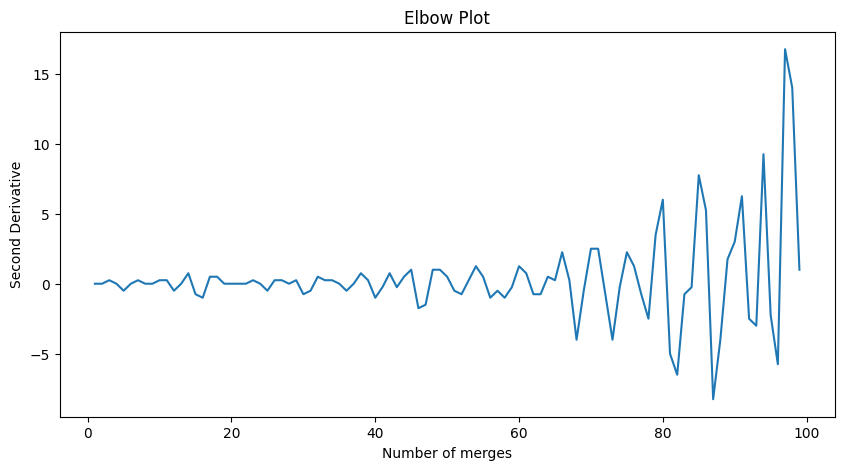

In [42]:
second_derivative = np.gradient(np.gradient(inconsistencies[:, 2]))
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(second_derivative) + 1), second_derivative)
plt.xlabel('Number of merges')
plt.ylabel('Second Derivative')
plt.title('Elbow Plot')
plt.show()


In [34]:
# ! pip install hdbscan

In [35]:
import hdbscan

clusterer = hdbscan.HDBSCAN()
cluster_labels = clusterer.fit_predict(text_embedding)

In [36]:
cluster_labels

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])

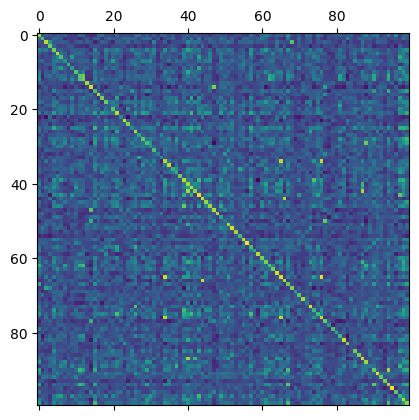

In [37]:
plt.matshow(similarity_texts_images[np.argsort(cluster_labels), :][:, np.argsort(cluster_labels)])

In [52]:
from openTSNE import TSNE
from umap import UMAP


In [97]:
# dataset = data.DiffusionDB_Dataset(path="2m_first_1k", batch_size=100)
dataset = data.MSCOCO_Val_Dataset(path='/Users/christina/Data/mscoco/validation/', batch_size=1000)
all_images, all_prompts, dataset_name = get_data_helper(dataset, filters=[], method=any) # filters = ["dog"], method=all
dataset_name

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


/Users/christina/anaconda3/envs/myenv/lib/python3.9/site-packages/clipexplorer/data.py:97: FutureWarning:

The input object of type 'Image' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Image', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.



1000


/Users/christina/anaconda3/envs/myenv/lib/python3.9/site-packages/clipexplorer/data.py:97: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



'MSCOCO-Val_size-1000'

In [98]:
image_embedding, text_embedding = get_embedding('CLIP', dataset_name, all_images, all_prompts)

clip_embeddings = torch.cat([image_embedding, text_embedding], dim=0)
clip_embeddings.shape


torch.Size([2000, 1024])

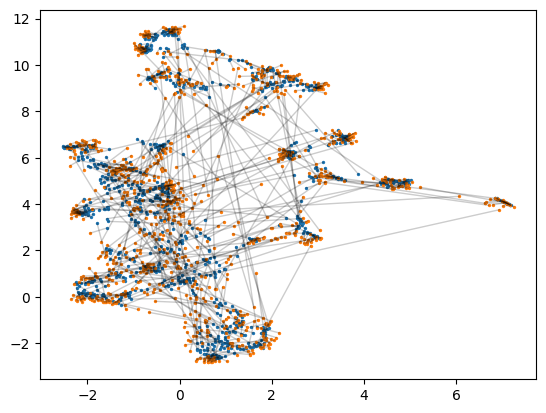

In [99]:
umap_proj = UMAP(
    random_state=31415,
    metric='cosine'
)
pre_emb = umap_proj.fit_transform(image_embedding)
oos_emb = umap_proj.transform(text_embedding)
plt.scatter(pre_emb[:,0], pre_emb[:,1], s=2)
plt.scatter(oos_emb[:,0], oos_emb[:,1], s=2)

for line_idx in range(len(pre_emb)):
    plt.plot((pre_emb[line_idx,0], oos_emb[line_idx,0]), (pre_emb[line_idx,1], oos_emb[line_idx,1]), 'black', linestyle='-', marker='', linewidth=1, alpha=0.2)


In [45]:
import numpy as np
from scipy.spatial.distance import cdist


(200, 200)

/Users/christina/anaconda3/envs/myenv/lib/python3.9/site-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



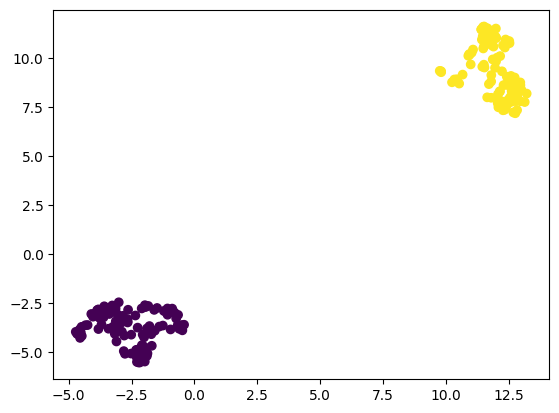

In [66]:

# Calculate pairwise Euclidean distance
distances = cdist(clip_embeddings, clip_embeddings, metric='cosine')

umap_proj = UMAP(
    metric="precomputed",
    random_state=31415
)
pre_emb = umap_proj.fit_transform(distances)
plt.scatter(pre_emb[:,0], pre_emb[:,1], c=[0]*100 + [1]*100)

/Users/christina/anaconda3/envs/myenv/lib/python3.9/site-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



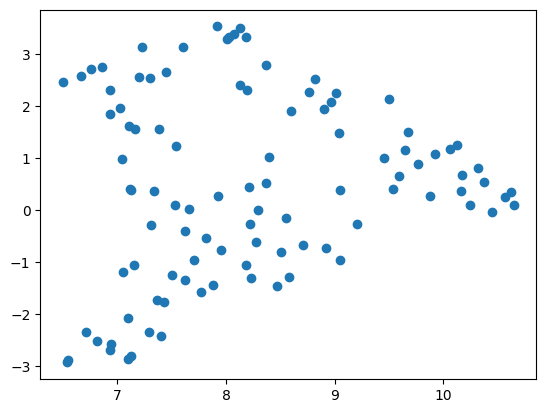

In [71]:

# Calculate pairwise Euclidean distance
distances = cdist(image_embedding, image_embedding, metric='cosine')

umap_proj = UMAP(
    metric="precomputed",
    random_state=31415
)
cross_emb = umap_proj.fit_transform(distances)
plt.scatter(cross_emb[:,0], cross_emb[:,1])

/Users/christina/anaconda3/envs/myenv/lib/python3.9/site-packages/umap/umap_.py:2830: UserWarning:

Transforming new data with precomputed metric. We are assuming the input data is a matrix of distances from the new points to the points in the training set. If the input matrix is sparse, it should contain distances from the new points to their nearest neighbours or approximate nearest neighbours in the training set.



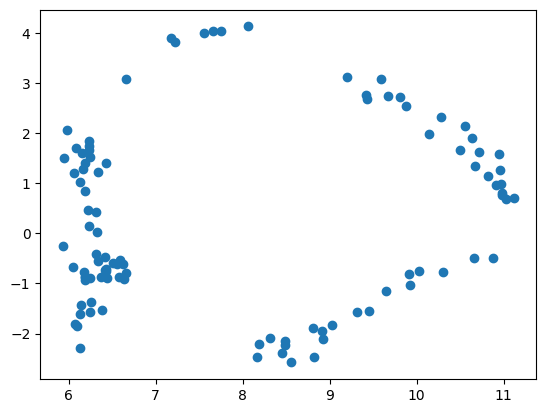

In [75]:
distances = cdist(image_embedding, text_embedding, metric='cosine')
inmodal_text_emb = umap_proj.transform(distances)
plt.scatter(inmodal_text_emb[:,0], inmodal_text_emb[:,1])

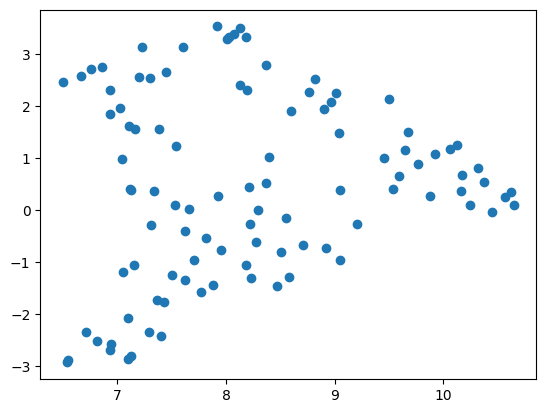

In [76]:
distances = cdist(image_embedding, image_embedding, metric='cosine')
inmodal_image_emb = umap_proj.transform(distances)
plt.scatter(inmodal_image_emb[:,0], inmodal_image_emb[:,1])

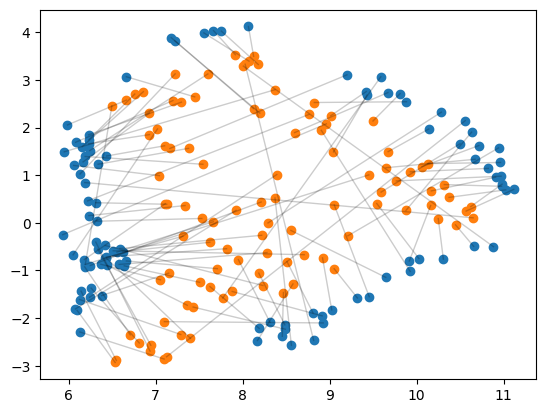

In [77]:

plt.scatter(inmodal_text_emb[:,0], inmodal_text_emb[:,1])
plt.scatter(inmodal_image_emb[:,0], inmodal_image_emb[:,1])

for line_idx in range(len(inmodal_image_emb)):
    plt.plot((inmodal_text_emb[line_idx,0], inmodal_image_emb[line_idx,0]), (inmodal_text_emb[line_idx,1], inmodal_image_emb[line_idx,1]), 'black', linestyle='-', marker='', linewidth=1, alpha=0.2)


Attempting to use `pca` initalization, but using precomputed distance matrix! Using `spectral` initilization instead, which doesn't need access to the data matrix.


--------------------------------------------------------------------------------
TSNE(early_exaggeration=12, metric='precomputed', n_jobs=8, random_state=31415,
     verbose=True)
--------------------------------------------------------------------------------
===> Calculating affinity matrix...
   --> Time elapsed: 0.01 seconds
===> Calculating spectral initialization...
   --> Time elapsed: 0.01 seconds
===> Running optimization with exaggeration=12.00, lr=8.33 for 250 iterations...
Iteration   50, KL divergence -0.4706, 50 iterations in 0.0202 sec
Iteration  100, KL divergence 0.8773, 50 iterations in 0.0121 sec
Iteration  150, KL divergence 0.8773, 50 iterations in 0.0130 sec
Iteration  200, KL divergence 0.8773, 50 iterations in 0.0119 sec
Iteration  250, KL divergence 0.8773, 50 iterations in 0.0123 sec
   --> Time elapsed: 0.07 seconds
===> Running optimization with exaggeration=1.00, lr=100.00 for 500 iterations...
Iteration   50, KL divergence 0.4584, 50 iterations in 0.0179 s

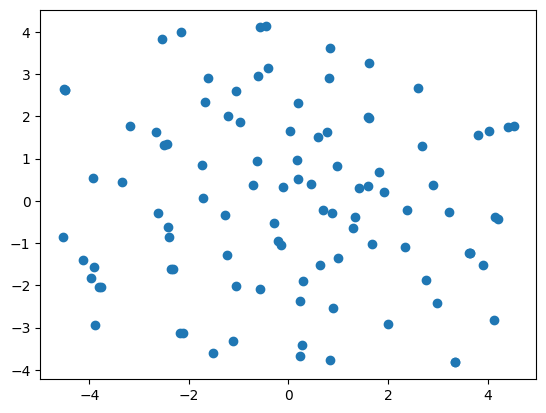

In [51]:

# Calculate pairwise Euclidean distance
distances = cdist(image_embedding, text_embedding, metric='euclidean')


tsne = TSNE(
    perplexity=30,
    metric="precomputed",
    n_jobs=8,
    verbose=True,
    random_state=31415
)
pre_emb = tsne.fit(distances)
plt.scatter(pre_emb[:,0], pre_emb[:,1])

Attempting to use `pca` initalization, but using precomputed distance matrix! Using `spectral` initilization instead, which doesn't need access to the data matrix.


--------------------------------------------------------------------------------
TSNE(early_exaggeration=12, metric='precomputed', n_jobs=8, random_state=31415,
     verbose=True)
--------------------------------------------------------------------------------
===> Calculating affinity matrix...
   --> Time elapsed: 0.01 seconds
===> Calculating spectral initialization...
   --> Time elapsed: 0.01 seconds
===> Running optimization with exaggeration=12.00, lr=16.67 for 250 iterations...
Iteration   50, KL divergence 1.2609, 50 iterations in 0.0514 sec
Iteration  100, KL divergence 1.3132, 50 iterations in 0.0511 sec
Iteration  150, KL divergence 1.3116, 50 iterations in 0.0410 sec
Iteration  200, KL divergence 1.3118, 50 iterations in 0.0354 sec
Iteration  250, KL divergence 1.3120, 50 iterations in 0.0327 sec
   --> Time elapsed: 0.21 seconds
===> Running optimization with exaggeration=1.00, lr=200.00 for 500 iterations...
Iteration   50, KL divergence 0.4158, 50 iterations in 0.0315 s

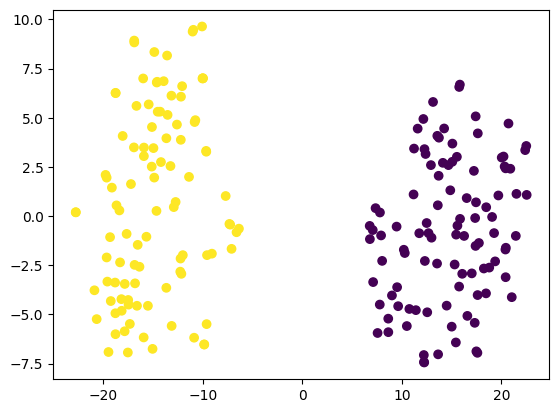

In [49]:

# Calculate pairwise Euclidean distance
distances = cdist(clip_embeddings, clip_embeddings, metric='euclidean')


tsne = TSNE(
    perplexity=30,
    metric="precomputed",
    n_jobs=8,
    verbose=True,
    random_state=31415
)
pre_emb = tsne.fit(distances)
plt.scatter(pre_emb[:,0], pre_emb[:,1], c=[0]*100 + [1]*100)

--------------------------------------------------------------------------------
TSNE(early_exaggeration=12, n_jobs=8, random_state=31415, verbose=True)
--------------------------------------------------------------------------------
===> Finding 90 nearest neighbors using exact search using euclidean distance...
   --> Time elapsed: 0.01 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.01 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.02 seconds
===> Running optimization with exaggeration=12.00, lr=16.67 for 250 iterations...
Iteration   50, KL divergence 1.2626, 50 iterations in 0.0479 sec
Iteration  100, KL divergence 1.3132, 50 iterations in 0.0429 sec
Iteration  150, KL divergence 1.3117, 50 iterations in 0.0404 sec
Iteration  200, KL divergence 1.3121, 50 iterations in 0.0377 sec
Iteration  250, KL divergence 1.3114, 50 iterations in 0.0346 sec
   --> Time elapsed: 0.20 seconds
===> Running optimization with exaggeration=1.00, lr=200

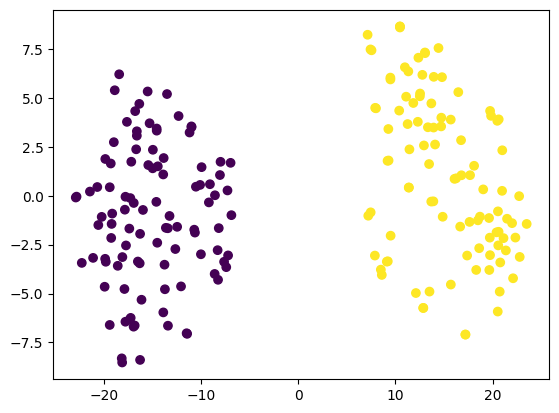

In [50]:

tsne = TSNE(
    perplexity=30,
    metric="euclidean",
    n_jobs=8,
    verbose=True,
    random_state=31415
)
emb = tsne.fit(clip_embeddings)

plt.scatter(emb[:,0], emb[:,1], c=[0]*100 + [1]*100)

In [ ]:
proj = UMAP(random_state=31415)
image_embedding, text_embedding = get_embedding('CLIP', dataset_name, all_images, all_prompts)
proj.fit_transform(image_embedding)

In [28]:
proj = UMAP(random_state=31415)
image_embedding, text_embedding = get_embedding('CLIP', dataset_name, all_images, all_prompts)
proj.fit_transform(image_embedding)

found cached embeddings for DiffusionDB_CLIP_RN50


array([[ 6.428579 , 12.1170435],
       [ 7.3216286, 11.596118 ],
       [ 8.273506 ,  9.722697 ],
       [ 9.890045 ,  9.643735 ],
       [ 4.224749 , 10.27259  ],
       [ 6.7272987, 12.368831 ],
       [ 5.5905514,  9.9505205],
       [ 5.2578363, 11.067748 ],
       [ 4.038863 , 10.266671 ],
       [ 7.6966085, 11.857719 ],
       [ 7.3442383, 12.378618 ],
       [ 5.9439845, 10.396751 ],
       [ 7.9402604, 10.537137 ],
       [ 6.5722127,  9.016514 ],
       [ 6.5561447, 11.021238 ],
       [ 7.138553 , 10.448707 ],
       [ 7.383331 ,  8.401202 ],
       [ 8.49693  ,  9.105027 ],
       [ 4.082005 ,  9.81599  ],
       [ 9.858314 , 10.383168 ],
       [ 8.660701 ,  9.605937 ],
       [ 4.9670076, 10.5122385],
       [ 9.670716 , 10.219148 ],
       [ 6.18907  , 10.247546 ],
       [ 6.808938 , 10.918122 ],
       [ 7.7875185,  9.441229 ],
       [ 7.7119193,  9.781385 ],
       [ 4.383856 ,  9.102676 ],
       [ 9.926729 ,  9.915797 ],
       [ 6.968334 , 12.763501 ],
       [ 6

In [ ]:

from datasets import load_dataset
# ds = load_dataset('poloclub/diffusiondb', '2m_text_only')
ds = load_dataset('poloclub/diffusiondb', '2m_first_10k')
ds

In [ ]:
prompts = ds['train']['prompt']

In [ ]:
subset_ids = [i for i in range(len(prompts)) if 'kitchen' in prompts[i]]
len(subset_ids)

In [ ]:
prompts[subset_ids]

In [ ]:

import webdataset as wds
url = "file:/Users/christina/Data/mscoco/bench/{00000..00591}.tar" # http://storage.googleapis.com/nvdata-openimages/openimages-train-000000.tar"
        
dataset = wds.WebDataset(url).shuffle(10000).decode("pil").rename(text="txt", json="json").to_tuple("text", "json").batched(10000)#.map_dict(image=preprocess, text=lambda text: clip.tokenize(text, truncate=True)[0], json=lambda json: json).to_tuple("image", "text", "json")
# dataloader = torch.utils.data.DataLoader(dataset, num_workers=4, batch_size=None)

In [ ]:
def my_filter(data):
    txt, _ = data
    return 'kitchen' in txt.lower()

dataset = wds.WebDataset(url).decode("pil").rename(text="txt", json="json").to_tuple("text", "json").select(my_filter)


In [ ]:

from itertools import islice
list(islice(dataset, 10))

In [ ]:
import webdataset as wds
url = "file:/Users/christina/Data/mscoco/bench/{00000..00591}.tar" # http://storage.googleapis.com/nvdata-openimages/openimages-train-000000.tar"
      
# dataset = wds.WebDataset(url).decode("pil").rename(text="txt", json="json").to_tuple("text", "json")#.map_dict(image=preprocess, text=lambda text: clip.tokenize(text, truncate=True)[0], json=lambda json: json).to_tuple("image", "text", "json")
import torch
def my_filter(data):
    txt, _ = data
    return 'young girl' in txt.lower()
    # return True
dataset = wds.WebDataset(url).decode("pil").rename(text="txt", json="json").to_tuple("text", "json").select(my_filter).shuffle(100).batched(10)#.map_dict(image=preprocess, text=lambda text: clip.tokenize(text, truncate=True)[0], json=lambda json: json).to_tuple("image", "text", "json")
# dataloader = torch.utils.data.DataLoader(dataset, num_workers=4, batch_size=None)
# all_images, all_prompts = next(iter(dataloader))
# all_images, all_prompts
# for data in dataset:
#     print(data)


from itertools import islice
# list(islice(dataset, 10000))
# next(iter(dataset))

In [ ]:
all_images, all_prompts = dataset.get_data()

In [ ]:
all_images[0]

In [ ]:
import torch
import torchvision.transforms as transforms

# Define the transformation pipeline
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=90),
    # transforms.RandomCrop(size=(224, 224)),
    # transforms.ToTensor(),
])

In [ ]:
noise_level = 1/10
image_array = np.array(all_images[0])
images = []
for i in range(10):
    noise = np.random.randint(low=0, high=256, size=image_array.shape,dtype='uint8')
    noisy_image_array = np.clip((1-i*noise_level)*image_array + i*noise_level*noise, 0, 255).astype('uint8')
    noisy_image = Image.fromarray(noisy_image_array)
    display(noisy_image)

In [ ]:
def create_expanded_button(description, button_style):
    return widgets.Button(description=description, button_style=button_style, layout=widgets.Layout(height='auto', width='auto'))


grid = widgets.GridspecLayout(4, 2)
grid[0,0] = create_expanded_button('One', 'success')
grid[0,1] = create_expanded_button('Two', 'info')
grid[1,0] = create_expanded_button('Three', 'warning')
grid[1,1] = create_expanded_button('Three', 'warning')

grid[0,0].layout.height = '500px'
grid[0,1].layout.height = '500px'
grid[1,1].layout.height = '500px'

widgets.AppLayout(header=widgets.Button(description='right', button_style='info', layout=widgets.Layout(height='20px', width='auto')),
          left_sidebar=None,
          center=grid,
          right_sidebar=widgets.Button(description='right', button_style='info', layout=widgets.Layout(height='500px', width='auto')),
          footer=None,
          height='500px')